# Predicting Future Sales

## Data Description

### File descriptions

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.



### Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category


### Dataset Link



#### [Here](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)

In [1]:
pip install xlrd

     |████████████████████████████████| 96 kB 2.9 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install autoviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import Lab
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy import optimize, stats   
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from keras.utils import np_utils

In [4]:
df_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
df_shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
df_items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
df_item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

In [5]:
df_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [6]:
df_test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [8]:
df_train.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03

In [9]:
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [10]:
df_test.isna().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [11]:
df_train

date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  
0                 1.0  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1.0  
...               ...  
2935844           1.0  
2935845           1.0  
2935846           1.0  
2935847           1.0  
2935848           1.0  

[2935849 rows x 6 columns]

Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.
Shape of your Data Set: (2935849, 6)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  1
    Number of Integer-Categorical Columns =  3
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  1
    Number of NLP String Columns =  

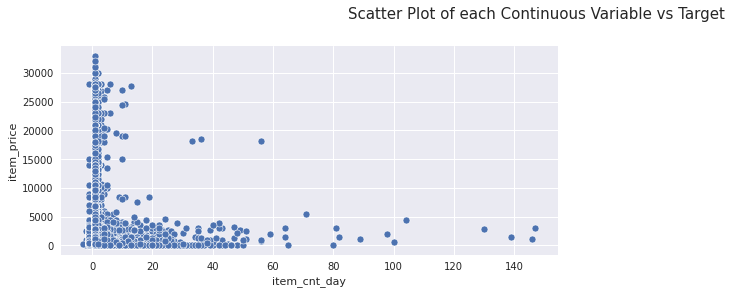

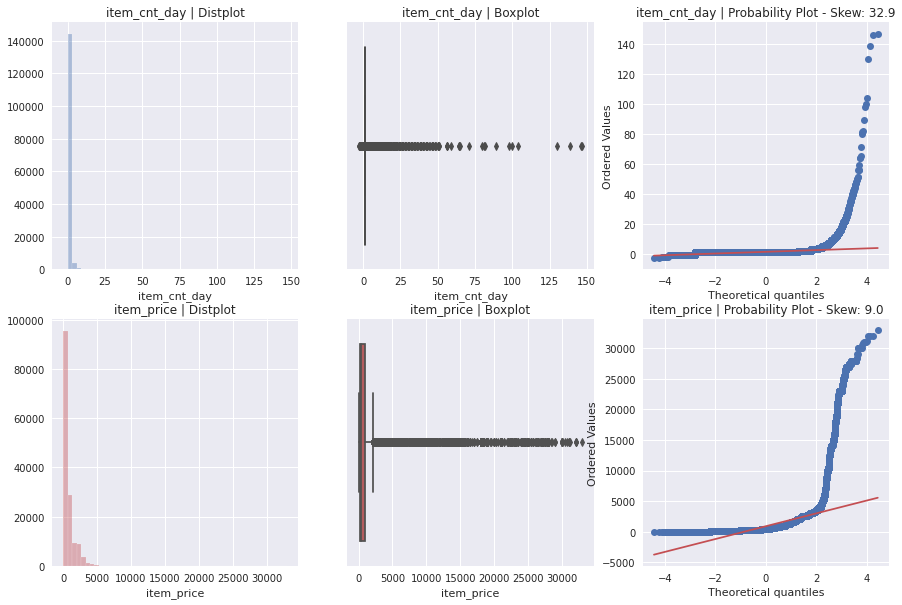

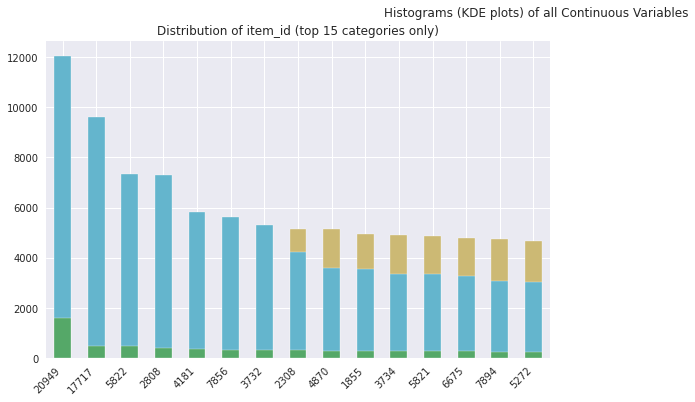

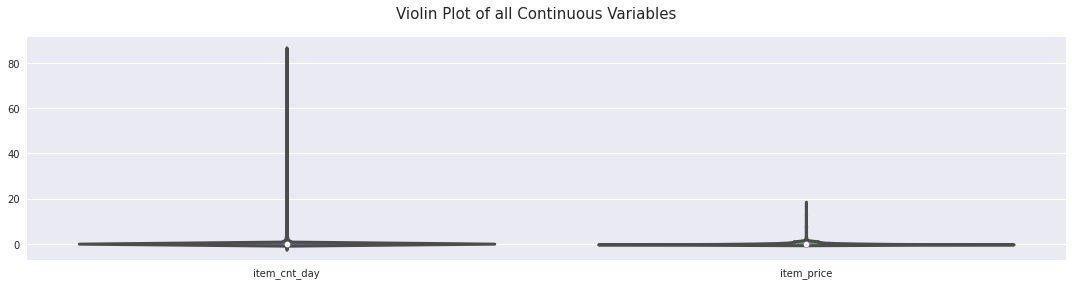

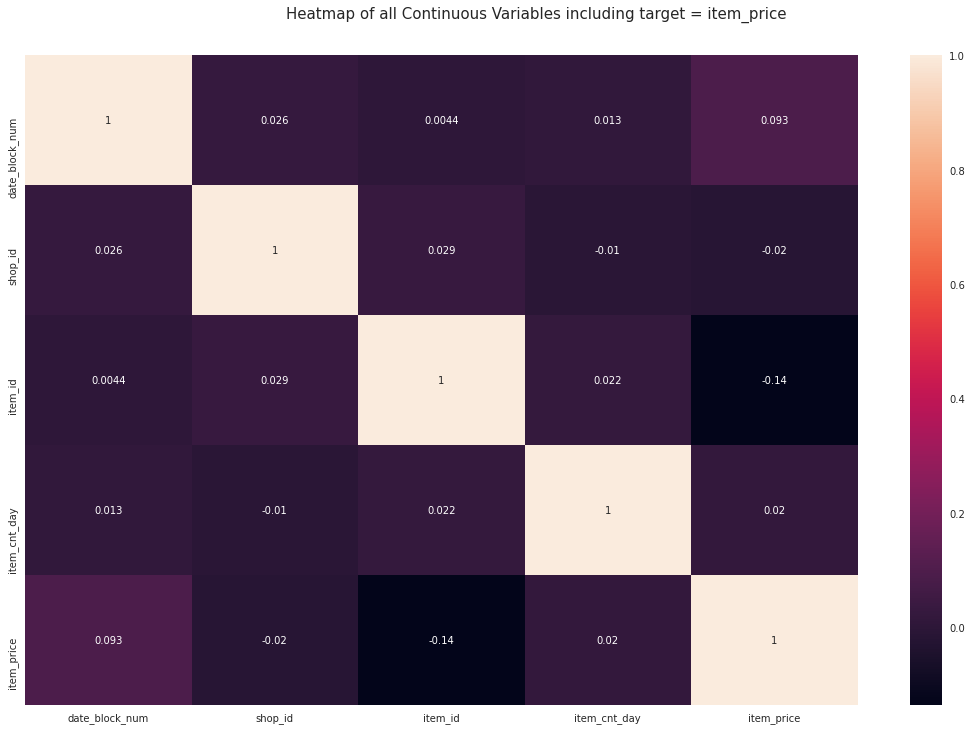

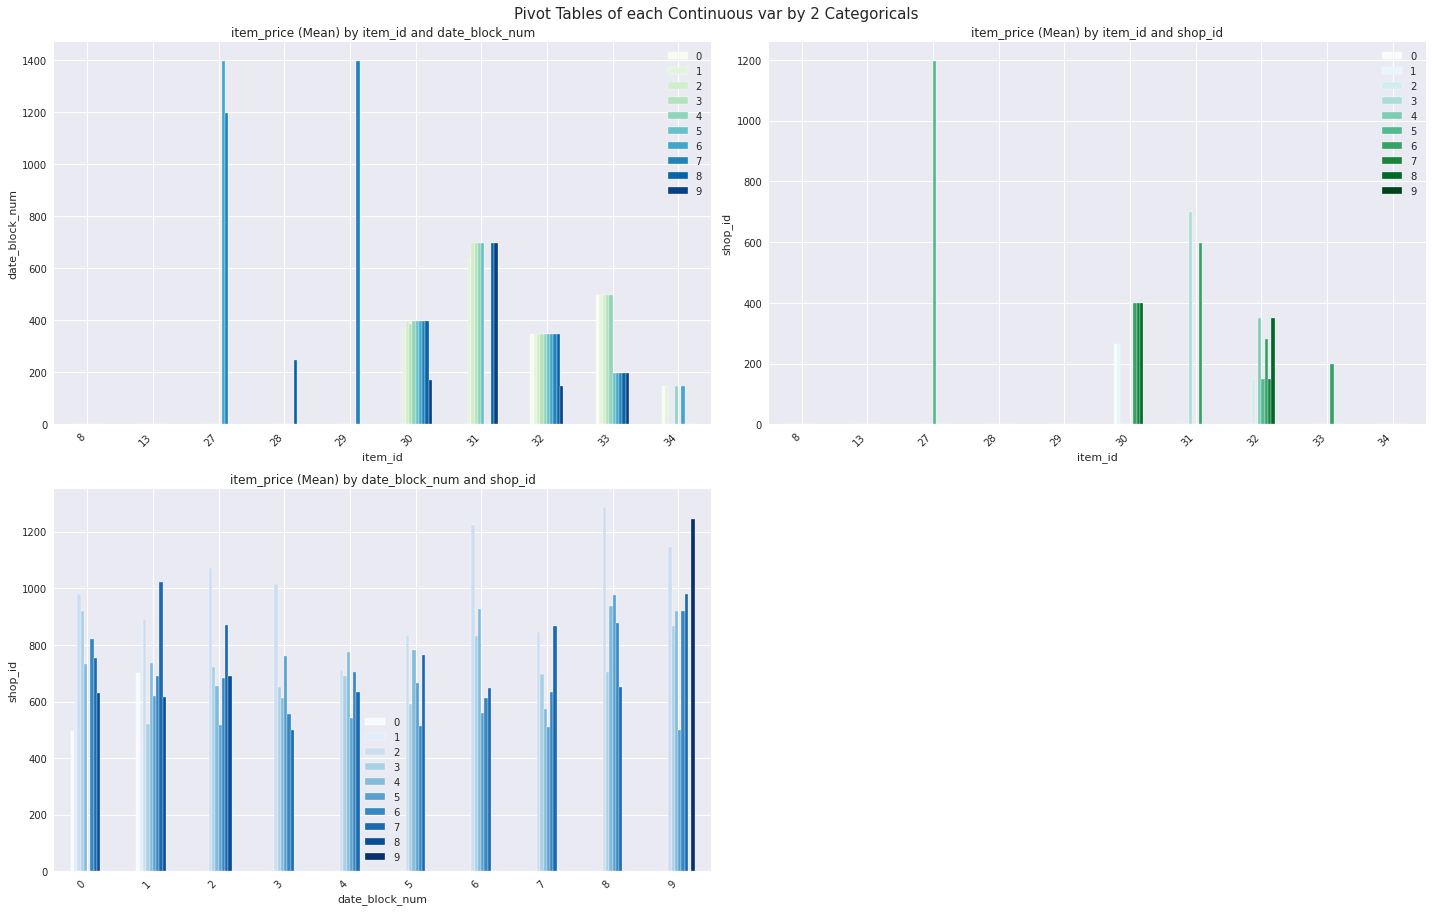

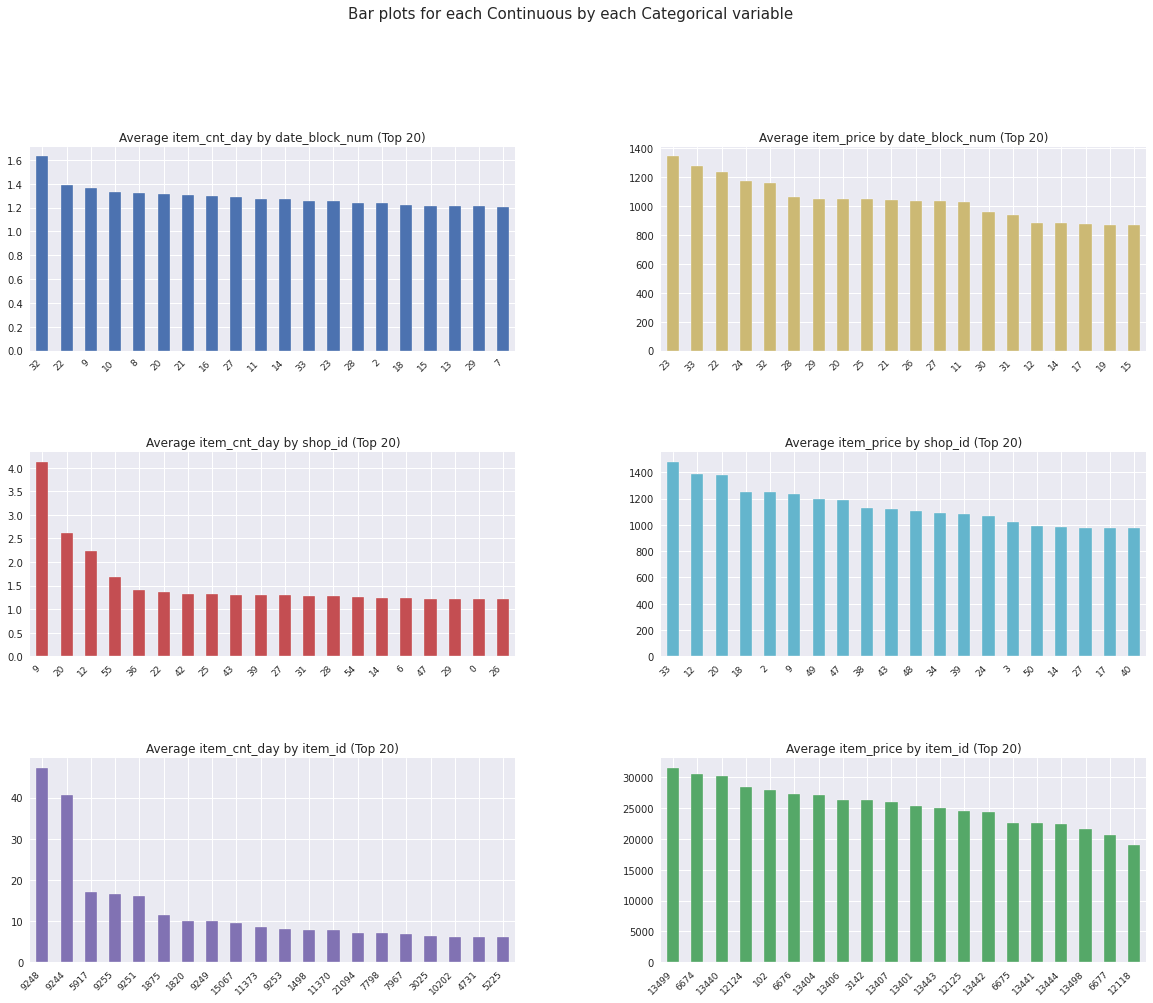

All Plots done
Time to run AutoViz (in seconds) = 12.364

 ###################### VISUALIZATION Completed ########################


In [12]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
target='item_price'
df = AV.AutoViz(filename="",sep=',', depVar=target, dfte=df_train, header=0, verbose=1, 
                 lowess=False, chart_format='svg', max_rows_analyzed=150000, max_cols_analyzed=30)

In [13]:
import pandas_profiling as pp
pp.ProfileReport(df_train)

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
import pandas_profiling as pp
pp.ProfileReport(df_shops)

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
import pandas_profiling as pp
pp.ProfileReport(df_items)

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
import pandas_profiling as pp
pp.ProfileReport(df_test)

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
df_train.drop(['date_block_num','item_price'], axis=1, inplace=True)

In [18]:
df_train.head()

date  shop_id  item_id  item_cnt_day
0  02.01.2013       59    22154           1.0
1  03.01.2013       25     2552           1.0
2  05.01.2013       25     2552          -1.0
3  06.01.2013       25     2554           1.0
4  15.01.2013       25     2555           1.0

In [19]:
df_train['date'] = pd.to_datetime(df_train['date'], dayfirst=True)
df_train['date'] = df_train['date'].apply(lambda x: x.strftime('%Y-%m'))
df_train.head()

date  shop_id  item_id  item_cnt_day
0  2013-01       59    22154           1.0
1  2013-01       25     2552           1.0
2  2013-01       25     2552          -1.0
3  2013-01       25     2554           1.0
4  2013-01       25     2555           1.0

In [20]:
df = df_train.groupby(['date','shop_id','item_id']).sum()
df = df.pivot_table(index=['shop_id','item_id'], columns='date', values='item_cnt_day', fill_value=0)
df.reset_index(inplace=True)
df.head().T

0   1   2   3   4
date                       
shop_id   0   0   0   0   0
item_id  30  31  32  33  35
2013-01   0   0   6   3   1
2013-02  31  11  10   3  14
2013-03   0   0   0   0   0
2013-04   0   0   0   0   0
2013-05   0   0   0   0   0
2013-06   0   0   0   0   0
2013-07   0   0   0   0   0
2013-08   0   0   0   0   0
2013-09   0   0   0   0   0
2013-10   0   0   0   0   0
2013-11   0   0   0   0   0
2013-12   0   0   0   0   0
2014-01   0   0   0   0   0
2014-02   0   0   0   0   0
2014-03   0   0   0   0   0
2014-04   0   0   0   0   0
2014-05   0   0   0   0   0
2014-06   0   0   0   0   0
2014-07   0   0   0   0   0
2014-08   0   0   0   0   0
2014-09   0   0   0   0   0
2014-10   0   0   0   0   0
2014-11   0   0   0   0   0
2014-12   0   0   0   0   0
2015-01   0   0   0   0   0
2015-02   0   0   0   0   0
2015-03   0   0   0   0   0
2015-04   0   0   0   0   0
2015-05   0   0   0   0   0
2015-06   0   0   0   0   0
2015-07   0   0   0   0   0
2015-08   0   0   0   0   0
2015-09   0   0   0   0   0
2015-10   0   0   0   0   0

In [21]:
df_test = pd.merge(df_test, df, on=['shop_id','item_id'], how='left')
df_test.drop(['ID', '2013-01'], axis=1, inplace=True)
df_test = df_test.fillna(0)
df_test.head().T

0       1       2       3       4
shop_id     5.0     5.0     5.0     5.0     5.0
item_id  5037.0  5320.0  5233.0  5232.0  5268.0
2013-02     0.0     0.0     0.0     0.0     0.0
2013-03     0.0     0.0     0.0     0.0     0.0
2013-04     0.0     0.0     0.0     0.0     0.0
2013-05     0.0     0.0     0.0     0.0     0.0
2013-06     0.0     0.0     0.0     0.0     0.0
2013-07     0.0     0.0     0.0     0.0     0.0
2013-08     0.0     0.0     0.0     0.0     0.0
2013-09     0.0     0.0     0.0     0.0     0.0
2013-10     0.0     0.0     0.0     0.0     0.0
2013-11     0.0     0.0     0.0     0.0     0.0
2013-12     0.0     0.0     0.0     0.0     0.0
2014-01     0.0     0.0     0.0     0.0     0.0
2014-02     0.0     0.0     0.0     0.0     0.0
2014-03     0.0     0.0     0.0     0.0     0.0
2014-04     0.0     0.0     0.0     0.0     0.0
2014-05     0.0     0.0     0.0     0.0     0.0
2014-06     0.0     0.0     0.0     0.0     0.0
2014-07     0.0     0.0     0.0     0.0     0.0
2014-08     0.0     0.0     0.0     0.0     0.0
2014-09     1.0     0.0     0.0     0.0     0.0
2014-10     0.0     0.0     0.0     0.0     0.0
2014-11     1.0     0.0     0.0     0.0     0.0
2014-12     2.0     0.0     0.0     0.0     0.0
2015-01     2.0     0.0     0.0     0.0     0.0
2015-02     0.0     0.0     0.0     0.0     0.0
2015-03     0.0     0.0     0.0     0.0     0.0
2015-04     0.0     0.0     0.0     0.0     0.0
2015-05     1.0     0.0     3.0     0.0     0.0
2015-06     1.0     0.0     2.0     0.0     0.0
2015-07     1.0     0.0     0.0     0.0     0.0
2015-08     3.0     0.0     1.0     1.0     0.0
2015-09     1.0     0.0     3.0     0.0     0.0
2015-10     0.0     0.0     1.0     0.0     0.0

In [22]:
# split into train and test sets
Y_train = df['2015-10'].values
X_train = df.drop(['2015-10'], axis = 1)
X_test = df_test

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(424124, 35) (424124,)
(214200, 35)


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split( X_train, Y_train, test_size=0.20, random_state=1)

In [24]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

NameError: name 'x_train' is not defined

In [25]:
Y_test

array([0, 0, 0, ..., 0, 0, 3])

In [26]:
%time
ETR = ExtraTreesRegressor(n_estimators=100, random_state=0)
ETR.fit(X_train,Y_train)

print('Train set mse:', mean_squared_error(Y_train, ETR.predict(X_train)))
print('Test set mse:', mean_squared_error(Y_test, ETR.predict(X_test)))
print('Test set score:', ETR.score(X_train,Y_train))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Train set mse: 0.0
Test set mse: 1.4188226749189508
Test set score: 1.0


In [27]:
%time
ADB= AdaBoostRegressor(random_state=0, n_estimators=100)
ADB.fit(X_train,Y_train)

print('Train set mse:', mean_squared_error(Y_train, ADB.predict(X_train)))
print('Test set mse:', mean_squared_error(Y_test, ADB.predict(X_test)))
print('Test set score:', ADB.score(X_train,Y_train))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
Train set mse: 2.3760595688581354
Test set mse: 2.0872338631564724
Test set score: 0.879057437225235


In [28]:
%time
BYNR = linear_model.BayesianRidge()
BYNR.fit(X_train,Y_train)

print('Train set mse:', mean_squared_error(Y_train, BYNR.predict(X_train)))
print('Test set mse:', mean_squared_error(Y_test, BYNR.predict(X_test)))
print('Test set score:', BYNR.score(X_train,Y_train))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Train set mse: 11.035196896144681
Test set mse: 5.214828053634467
Test set score: 0.4383032265536795


In [29]:
%time
LR = LinearRegression()
LR.fit(X_train,Y_train)

print('Train set mse:', mean_squared_error(Y_train, LR.predict(X_train)))
print('Test set mse:', mean_squared_error(Y_test, LR.predict(X_test)))
print('Test set score:', LR.score(X_train,Y_train))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs
Train set mse: 11.035196010127327
Test set mse: 5.216807254420307
Test set score: 0.4383032716523845


In [30]:
%time
RFR = RandomForestRegressor(n_estimators = 100)
RFR.fit(X_train,Y_train)

print('Train set mse:', mean_squared_error(Y_train, RFR.predict(X_train)))
print('Test set mse:', mean_squared_error(Y_test, RFR.predict(X_test)))
print('Test set score:', RFR.score(X_train,Y_train))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Train set mse: 2.458241471681318
Test set mse: 0.7540185145888594
Test set score: 0.8748743392627882


In [31]:
%time
XGB = XGBRegressor(max_depth=16,n_estimators=200,seed=1)
XGB.fit(X_train,Y_train)

print('Train set mse:', mean_squared_error(Y_train, XGB.predict(X_train)))
print('Test set mse:', mean_squared_error(Y_test, XGB.predict(X_test)))
print('Test set score:', XGB.score(X_train,Y_train))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Train set mse: 0.01816715629513515
Test set mse: 0.893909188595394
Test set score: 0.9990752830991863


In [32]:
%time
LGBM = LGBMRegressor(max_depth=16,n_estimators=200,seed=1)
LGBM.fit(X_train,Y_train)

print('Train set mse:', mean_squared_error(Y_train, LGBM.predict(X_train)))
print('Test set mse:', mean_squared_error(Y_test, LGBM.predict(X_test)))
print('Test set score:', LGBM.score(X_train,Y_train))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Train set mse: 5.777594430345526
Test set mse: 4.355020568961951
Test set score: 0.7059176940521745


In [33]:
prediction = XGB.predict(X_test)

In [34]:
prediction = list(map(round, prediction))

In [35]:
score_1 = 0.76 
score_2 = 0.87
score_3 = 0.43
score_4 = 0.43
score_5 = 0.88
score_6 = 0.99
score_7 = 0.70 

results = pd.DataFrame([["ExtraTreesRegressor",score_1],["AdaBoostRegressor",score_2],[" BayesianRidge",score_3],
                       ["LinearRegression",score_4],["RandomForestRegressor",score_5],
                       ["XGBRegressor",score_6],["RLGBMRegressor",score_7]],
                        columns = ["Models","Score"]).sort_values(by='Score',ascending=False)


results.style.background_gradient(cmap='Blues')